# packages needed to run this file:
- install externally: bedtools 2.26.x
- conda install pandas pybedtools matplotlib seaborn numpy tqdm gffutils
### (if possible, install bedtools from source, or be aware of issue: https://github.com/arq5x/bedtools2/issues/471)

In [3]:
%matplotlib inline
import pandas as pd
import pybedtools as bt
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import numpy as np
import math
import pybedtools
import gffutils
from tqdm import tnrange, tqdm_notebook
from collections import OrderedDict, defaultdict
pd.set_option("display.max_rows",500)
gffhead = ['seqname','source','feature','start','end','score','strand','frame','attribute']

# Define constants and annotations

In [4]:
geneset = 'ws254'
# insert the location of the latest version of bedtools ( to fix closest bug )
BEDTOOLS = '/projects/ps-yeolab/software/bedtools-2.26.20170404/bedtools2/bin/bedtools'
# original gff file contains a bunch of other annotations we don't want to use... let's just use wormbase.
original_gff = '/projects/ps-yeolab3/bay001/annotations/c_elegans.PRJNA13758.WS254.annotations.gff3'
# list of validated differentially expressed genes by qPCR
VALIDATED = ['WBGene00007153','WBGene00000831','WBGene00022644','WBGene00002013','WBGene00009242']

# Specify input directory and files

In [5]:
# directory where the bam files are. Needed only for exon coverage calculations.
bamdir = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/rnae_v6' 
# known edited genes (used to intersect called events with known edited genes)
existing_transcripts = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/data/other_papers_called_transcripts.tab' 
# adr1 RIP targets (used to intersect edited genes with genes bound by adr1)
adr_common_targets_list = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/ADR-1-RIP-targets-sent-to-Yeo-lab-May-2017.txt' 
# list of validated events
validated_events_from_sarah = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/040517_supplemental_document_1_validated.events.csv' 
# go annotations downloaded from: http://geneontology.org/page/download-annotations
go_association_file = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/gene_association.wb' 
# deseq2 differential expression results table.
from_deseq2 = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/differential_expression/{}/diffexp.tsv'.format(
    geneset
) 

# filter settings
min_confidence = 0.99
# the endpoint of the pipeline
common_suffix = '.sorted.rmdup.readfiltered.formatted.varfiltered.snpfiltered.ranked.conf' 
# where all the pipeline results are
editing_calls_dir = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/editing_calls_v15_final/' 
wt_forward_conf = os.path.join(editing_calls_dir,'WT.fwd{}'.format(common_suffix))
wt_reverse_conf = os.path.join(editing_calls_dir,'WT.rev{}'.format(common_suffix))
ko_forward_conf = os.path.join(editing_calls_dir,'adr2ko.fwd{}'.format(common_suffix))
ko_reverse_conf = os.path.join(editing_calls_dir,'adr2ko.rev{}'.format(common_suffix))

editing_calls_dir = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/editing_test_against_aiden/'

# Specify output directory and files

In [6]:
output_directory = '/projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/editor_response_minor_1/{}/'.format(geneset)
known_snp_bed3file = os.path.join(output_directory,'known_snps.bed3')
editing_annotation_file = os.path.join(output_directory,'wormbase.gff3')
for_differential_expression = os.path.join(output_directory, '{}.saf'.format(geneset))
all_output_regions_piechart = os.path.join(output_directory,'all_pie.svg')
all_output_regions_annotations = os.path.join(output_directory,'annotations.txt')
all_output_regions_wbgene_annotations = os.path.join(output_directory,'annotations_wbgene.txt')
chemotaxis_locomotion_goterms = os.path.join(output_directory,'annotations_locomotion_and_chemotaxis.txt')
validation_comparisons = os.path.join(output_directory,'validation_comparisons.txt')
existing_transcripts_wbgene = os.path.join(output_directory, 'other_papers_called_transcripts.with_names.{}.tab'.format(geneset)) # known edited genes with wbgene names

supplemental_doc1_edited_genes = os.path.join(output_directory,'supplemental_doc_1.txt')
supplemental_doc1_sanger = os.path.join(output_directory,'supplemental_doc_1.sanger.txt')
supplemental_doc1_genes = os.path.join(output_directory,'supplemental_doc_1.genes.txt')
supplemental_doc1_novel = os.path.join(output_directory,'supplemental_doc_1.novel.txt')
supplemental_doc1_locomotion = os.path.join(output_directory,'supplemental_doc_1.locomotion.txt')

supplemental_doc2_upregulated_genes = os.path.join(output_directory,'supplemental_doc_2_upregulated_genes.txt')
supplemental_doc2_downregulated_genes = os.path.join(output_directory,'supplemental_doc_2_downregulated_genes.txt')

# Create the annotation file for editing
- re-format original file
- Just use wormbase annotations
- Re-name the 'I/II/III/etc. to chrI, chrII, chrIII, etc.'
- Re-name the 'M' chromosome to 'MtDNA'
- Pull out just the attributes 

In [7]:
def make_wormbase_and_format(original_gff, editing_annotation_file):
    """
    pulls just the wormbase annotations
    need to reformat the chromosome names from 'I, II' to 'chrI and chrII etc.'
    """
    original_gff_df = pd.read_table(original_gff,names=gffhead, comment='#')
    print("size of the original gff: {}".format(original_gff_df.shape[0]))  # wow... lots of entries
    wormbase = original_gff_df[original_gff_df['source']=='WormBase']
    wormbase['seqname'] = 'chr'+wormbase['seqname'].replace('MtDNA','M')
    wormbase[['start','end']] = wormbase[['start','end']].astype(int)  # change positions to INT from FLOAT
    wormbase.sort_values(by=['seqname','start','end'], inplace=True)
    wormbase.to_csv(editing_annotation_file, sep='\t', index=None, header=None)

    print("size of the wormbase gff: {}".format(wormbase.shape[0]))  # better...
    
if not os.path.exists(editing_annotation_file):
    make_wormbase_and_format(original_gff, editing_annotation_file)

# Create the SAF file for differential expression
- GFF3 isn't compatible with featureCounts, need to format into SAF.

In [8]:
def create_saf_file(original_gff, saf_file):
    original_gff_df = pd.read_table(original_gff,names=gffhead, comment='#')
    print("size of the original gff: {}".format(original_gff_df.shape[0]))  # wow... lots of entries
    wormbase = original_gff_df[(original_gff_df['source']=='WormBase') & (original_gff_df['feature']=='gene')]
    wormbase['seqname'] = 'chr'+wormbase['seqname'].replace('MtDNA','M')
    wormbase[['start','end']] = wormbase[['start','end']].astype(int)  # change positions to INT from FLOAT
    wormbase['GeneID'] = wormbase['attribute'].str.extract(":([\w\d\.]+)")
    wormbase = wormbase[['GeneID','seqname','start','end','strand']]
    wormbase.to_csv(saf_file, sep='\t', header=False, index=False)

if not os.path.exists(for_differential_expression):
    create_saf_file(original_gff, for_differential_expression)

# Create annotation file for known SNPs

In [9]:
# let's also parse this file while we have it to get the 'known SNP and point mutations'
def make_snp_file(original_gff, known_snp_bed3file):
    original_gff_df = pd.read_table(original_gff,names=gffhead)
    snp = original_gff_df[
        (original_gff_df['feature']=='SNP') | (original_gff_df['feature']=='point_mutation')
    ]
    snp['seqname_chr_formatted'] = 'chr' + snp['seqname']
    snp['start_formatted'] = snp['start'].astype(int) - 1
    snp['end_formatted'] = snp['end'].astype(int)
    snp = snp[['seqname_chr_formatted','start_formatted','end_formatted']]
    snp.drop_duplicates(inplace=True)
    print('number of snps and single point mutations: {}'.format(snp.shape[0]))
    snp.to_csv(known_snp_bed3file, sep='\t', index=False, header=False)

if not os.path.exists(known_snp_bed3file):
    make_snp_file(original_gff, known_snp_bed3file)
# original_gff

/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

number of snps and single point mutations: 1493826


# Run the editing pipeline
- Use the 'known_snps' bed3 file

# Run DESeq2 for differential expression
- Use the SAF file

# Analyses in this notebook:
- filter confidence, 
- remove 'false positives' from KO
- 'forward' and 'reverse' are designated based on editing site strand 
- annotation using bedtools and a gff3 file
- intersection of editing sites and differential expression
- intersection of editing sites and known edited genes from other publications
- intersection of editing sites and experimentally validated editing sites (sanger sequencing)
- intersection of editing sites and GO terms

# Define intermediate files
- this is where the intermediate bedfiles and things go.

In [10]:
wt_forward_bed = os.path.join(output_directory,'wt_forward.bed')
wt_reverse_bed = os.path.join(output_directory,'wt_reverse.bed')
ko_forward_bed = os.path.join(output_directory,'ko_forward.bed')
ko_reverse_bed = os.path.join(output_directory,'ko_reverse.bed')

wt_forward_sorted_bed = os.path.join(output_directory,'wt_forward.sorted.bed')
wt_reverse_sorted_bed = os.path.join(output_directory,'wt_reverse.sorted.bed')
ko_forward_sorted_bed = os.path.join(output_directory,'ko_forward.sorted.bed')
ko_reverse_sorted_bed = os.path.join(output_directory,'ko_reverse.sorted.bed')

editing_sites_conf_files = [wt_forward_conf, wt_reverse_conf, ko_forward_conf, ko_reverse_conf]
editing_sites_bed_files = [wt_forward_bed, wt_reverse_bed, ko_forward_bed, ko_reverse_bed]
editing_sites_sorted_bed_files = [wt_forward_sorted_bed, wt_reverse_sorted_bed, ko_forward_sorted_bed, ko_reverse_sorted_bed]

# Create annotations for translating name/id/wbgene/feature:

In [11]:
annotation_file = editing_annotation_file
annotation_db_file = editing_annotation_file.replace('.gff3','.db')

def build_db(annotation_file, annotation_db_file, force=False):
    db = gffutils.create_db(
        annotation_file, dbfn=annotation_db_file, force=force, # change to True if we need to create a new db
        keep_order=True, merge_strategy='merge', sort_attribute_values=True
    )

if not os.path.exists(annotation_db_file):
    print("db doesn't exist, building...")
    build_db(annotation_file, annotation_db_file)

DATABASE = gffutils.FeatureDB(annotation_db_file)

# Define methods for converting between gene names/ids

In [12]:
def gene_id_to_name(db, attribute='Name'):
    '''
    takes a gene id and returns the first name associated (one-to-one)
    '''
    # db = gffutils.FeatureDB(db)
    genes = db.features_of_type('gene')
    gene_name_dict = {}
    for gene in genes:
        gene_id = gene.attributes['Name'][0] if type(gene.attributes['Name']) == list else gene.attributes['Name']
        try:
            gene_name_dict[gene_id] = gene.attributes['Alias'][0]
        except KeyError:
            print("Warning. Key not found for {}".format(gene))
    return gene_name_dict

def gene_name_to_id(db, attribute='Name'):
    '''
    takes the name and returns a list of associated IDs (one-to-many)
    '''
    # db = gffutils.FeatureDB(db)
    genes = db.features_of_type('gene')
    gene_name_dict = defaultdict(list)
    for gene in genes:
        try:
            gene_name_dict[gene.attributes['sequence_name'][0]].append(gene.attributes['Name'][0])
        except KeyError as e:
            print(e)
            return 1
            # print("Warning. Key not found for {}".format(gene))
    return gene_name_dict

def gene_name_to_mrna(db, attribute='Name'):
    '''
    takes the name and returns a list of associated mRNA IDs (one-to-many)
    '''
    # db = gffutils.FeatureDB(db)
    genes = db.features_of_type('mRNA')
    gene_name_dict = defaultdict(list)
    for gene in genes:
        try:
            gene_name_dict[gene.attributes['Name'][0]].append(gene.attributes['Parent'][0].replace('Gene:',''))
        except KeyError as e:
            print(e)
            return 1
            # print("Warning. Key not found for {}".format(gene))
    return gene_name_dict


def gene_id_to_biotype(db):
    '''
    takes the id and returns a biotype (one-to-one)
    '''
    genes = db.features_of_type('gene')
    gene_name_dict = {}
    for gene in genes:
        try:
            gene_name_dict[gene.attributes['Name'][0]] = gene.attributes['biotype'][0]
        except KeyError as e:
            print(e)
            return 1
            # print("Warning. Key not found for {}".format(gene))
    return gene_name_dict

In [13]:
# create the database dictionaries 
id2name_dict = gene_id_to_name(DATABASE)
name2id_dict = gene_name_to_id(DATABASE)
name2mrna_dict = gene_name_to_mrna(DATABASE)
id2biotype_dict = gene_id_to_biotype(DATABASE)

# Define methods for assigning genic regions to editing sites

In [14]:
def get_id_from_name(row, name2id_dict=name2id_dict):
    """
    uses the dict to return id from name given our annotation dataframe
    """
    if len(name2id_dict[row['attributes']]) > 0:
        return name2id_dict[row['attributes']]
    else:
        return '-'

def get_mrna_from_name(row, name2mrna_dict=name2mrna_dict):
    """
    uses the dict to return mrna from name given our annotation dataframe
    """
    if len(name2mrna_dict[row['attributes']]) > 0:
        return name2mrna_dict[row['attributes']]
    else:
        return '-'

def id_to_biotype(row, id2biotype_dict=id2biotype_dict):
    """
    returns the biotype of a given row's region_id
    """
    return id2biotype_dict[row['region_id']]

def conf_to_bed(conf_file, output_bedfile, min_confidence):
    """
    Converts a "conf" file (vcf format) into a filtered bedfile.
    
    conf_file : string - filename of the intermediate 'conf' file from editing pipeline output
    output_bedfile : string - filename of the bed-formatted conf file
    min_confidence : float - min confidence (ie. 0.99) to call an editing site
    
    """
    print("Converting conf files to bedfiles: {}".format(conf_file))
    bedfile = open(output_bedfile,'w')
    with open(conf_file,'r') as f:
        for line in f:
            strand = '.'
            if not line.startswith('#'):
                line = line.split('\t')
                if line[3] == 'A':  # if the editing pipeline called the ref allele as A, the it's +
                    strand = '+'
                elif line[3] == 'T':  # if ref allele is T, strand is -
                    strand = '-'
                else:
                    print("WARN: Strand not correct")
                if float(line[5]) >= min_confidence:
                    bedfile.write(
                        "{0}\t{1}\t{2}\t{3}\t{4}\t{5}\n".format(
                            line[0],
                            int(line[1])-1,
                            line[1],
                            int(float(line[7])*100),
                            int(line[2]),
                            strand
                        )
                    )
    bedfile.close()
    
def is_intergenic(row):
    """
    Returns a region if the distance is either:
    1. within the region (0 bases away from feature)
    2. within 2000 bp upstream a 5'UTR feature
    3. withint 2000 bp downstream of a 3'UTR feature
    Else returns 'intergenic' if neither are present.
    
    row : pandas row
    
    """
    try:
        # bedtools closest found an intersection between a site and a feature
        if(row['distance_from_region'] == 0 ): 
            return row['region_type'].replace('_',' ')
        # bedtools closest found a feature downstream 
        elif(row['distance_from_region'] > 0 and 
             row['distance_from_region'] < 2000):
            # downstream feature is a gene
            if(('UTR' in row['region_type']) | \
               ('mRNA' in row['region_type']) | \
               ('CDS' in row['region_type'])
              ):
                return "downstream from gene"
            else:
                return "downstream from ncRNA"
        # bedtools closest found a feature upstream 
        elif(row['distance_from_region'] < 0 and 
             row['distance_from_region'] > -2000): 
            # upstream feature is a gene
            if(('UTR' in row['region_type']) | \
               ('mRNA' in row['region_type']) | \
               ('CDS' in row['region_type'])
              ):
                return "upstream from gene"
            else:
                return "upstream from ncRNA"
        else:
            return "intergenic"
    except TypeError:
        print(row)

# region priority
REGIONS = ['three prime UTR','five prime UTR',
           'CDS','intron',
           'mRNA','piRNA','ncRNA','tRNA','nc primary transcript',
           'miRNA','snoRNA','pre miRNA','lincRNA','snRNA','antisense RNA',
           'rRNA','miRNA primary transcript','scRNA', 'downstream from gene', 
           'upstream from gene', 'downstream from ncRNA', 'upstream from ncRNA', 
           'pseudogenic tRNA', 'pseudogenic transcript', 'exon']

def priority(row):
    """
    assign priority to the region given the regions defined
    
    row : pandas row
    
    return : int (0 being highest priority)
    
    """
    for i in range(0,len(REGIONS)):
        if row['region'] == REGIONS[i]:
            return i
    return len(REGIONS)


def tostring(row):
    """
    Concats the chrom:pos columns together. This will give each SNP a unique identifier.
    
    row : pandas row
    
    return : string
    """
    return "{}:{}".format(row['chrom'],row['pos'])


def get_closest(sites, genic_regions):
    """
    for every gene, get the closest gene feature
    
    sites : pybedtools.BedTool
    genic_regions : gff3 annotation file
    """
    annotations = sites.closest(
        genic_regions, 
        D='b',
        s=True).to_dataframe(
        names=[
            'chrom','pos-1','pos','approx_edit_fraction','approx_coverage','strand',
            'region_chrom','source','region_type','region_start','region_end','region_.',
            'region_strand','.','attributes','distance_from_region'
        ]
    )
    return annotations

def get_closest_fix(sites_file, genic_region_file, bedtools=BEDTOOLS):
    """
    Basically calls the dev version outside of this notebook. Drop-in replacement for 
    bedtools to use the dev. version because the current stable version is broken:
    https://github.com/arq5x/bedtools2/issues/471
    
    """
    
    tmp_output_file = 'closest.txt'
    cmd = BEDTOOLS
    cmd = cmd + ' closest'
    cmd = cmd + ' -a {}'.format(sites_file)
    cmd = cmd + ' -b {}'.format(genic_region_file)
    cmd = cmd + ' -D b' + ' -s'
    cmd = cmd + ' > {}'.format(tmp_output_file)
    ! $cmd
    df = read_closest_fix(tmp_output_file)
    return df

def read_closest_fix(f):
    """
    Reads the external file output from get_closest_fix and return a dataframe.
    """
    df = pd.read_table(f, sep='\t', names=[
            'chrom','pos-1','pos','approx_edit_fraction','approx_coverage','strand',
            'region_chrom','source','region_type','region_start','region_end','region_.',
            'region_strand','.','attributes','distance_from_region'
        ])
    return df

def assign_priority_and_remove_duplicate_assignments(annotations):
    """
    takes the closest region and distance and determines whether it is 'close enough'
    then reorders based on priority and makes sure only one region is called per site.
    
    annotations : pandas.DataFrame - dataframe of wt annotations
    """
    
    # Assign region and priority
    # annotations['region_type'] = annotations.apply(id_to_biotype,axis=1)
    annotations['region'] = annotations.apply(is_intergenic,axis=1)
    annotations['priority'] = annotations.apply(priority,axis=1)

    # Sort by ascending priority (1 is top)
    annotations.sort_values(
        by=['priority'],
        inplace=True,
        ascending=True
    )
    # Drop all but the first priority annotation
    
    annotations.drop_duplicates(
        subset=[
            'chrom','pos-1','pos','approx_coverage','approx_edit_fraction','strand'
        ],
        inplace=True,
        keep='first',
    )
    
    return annotations


def assign_false_positives(annotations):
    """
    given ko_annotations, return the str representation 
    
    annotations : pandas.DataFrame - dataframe containing KO annotations
    """
    falsepositives = []
    try:
        falsepositives = annotations.apply(tostring,axis=1)
        return list(set(falsepositives))
    except ValueError:
        print("no annotations found.")
        return []

# plot the pie chart.
def plot_pie(annotations, falsepositives, output_file):
    """
    plots a pie chart
    
    annotations : pandas.DataFrame
        table with all the wt annotations
    falsepositives : pandas.Series
        series with all of the 'stringified' false positive positions.
        Only really used to print the number in the title.
    output_file : string
        output file of the final annotation
        
    """
    allsites = float(annotations['region'].value_counts().sum()) # total assigned regions

    regions = OrderedDict(annotations['region'].value_counts())
    labels = regions.keys()
    nums = regions.values()
    pcts = [100*(n / allsites) for n in nums]

    colors = sns.color_palette("hls", len(labels))

    # Plot
    patches, texts = plt.pie(
        nums, colors=colors, shadow=False, startangle=140
    )
    
    labels = ['{0} - {1} ({2:1.2f} %)'.format(i,j,k) for i,j,k in zip(labels, nums, pcts)]
    
    plt.axis('equal')
    
    plt.title(
        'Editing Site Distribution by Region \n Events: {} AFTER removing {} Adr2-'.format(
            annotations.shape[0],
            len(falsepositives)
        ), y=1.08
    )
    
    lgd = plt.legend(
        patches, labels, loc='center right', bbox_to_anchor=(0.22, 0.5),
        fontsize=10, 
    )
    plt.tight_layout()
    # plt.subplots_adjust(top=0.7)
    plt.savefig(output_file, bbox_extra_artists=(lgd,), bbox_inches='tight')

def trim(df):
    cleaned = df['attributes'].str.extract(":([\w\d\.]+)")
    
    return cleaned
    
def format_annotations_nicely(annotations, falsepositives):
    """
    re-name the existing GFF annotations to be more friendly. (
    removes the stuff like Parent=Transcript: etc.).
    
    annotations : pandas.DataFrame
        table with all the wt annotations
    falsepositives : pandas.Series
        series with all of the 'stringified' false positive positions
    """
    
    annotations['id'] = trim(annotations)
    # chrompos serves as pivot for removing false positives
    annotations['chrompos'] = annotations.apply(tostring,axis=1)
    # remove the 'false positives'
    print("Before KO removal: {}".format(annotations.shape[0]))
    annotations = annotations[annotations['chrompos'].isin(falsepositives)==False]
    print("After KO removal: {}".format(annotations.shape[0]))
    # delete extraneous columns
    del annotations['region_type'] # closest region, unneeded after assigning region. This also doesn't include 'downstream' and 'upstream' annotations.
    del annotations['priority'] # don't need priority
    del annotations['region_.'] # don't even use this field
    del annotations['.'] # don't even use this field
    del annotations['chrompos'] # don't need this field after removing KO false positives
    del annotations['distance_from_region'] # comment this out if we want to see exactly where from a region the editing site lies.
    
    return annotations

def sort_bed(bed_file, sorted_bed_file):
    print("sorting {} > {}".format(bed_file, sorted_bed_file))
    bed_head = ['chrom','start','stop','name','score','strand']
    bed = pd.read_table(bed_file, names=bed_head)
    bed = pybedtools.BedTool.from_dataframe(bed).sort()
    bed = bed.to_dataframe()
    bed.to_csv(sorted_bed_file, sep='\t', index=False, header=False)
    return bed

In [15]:
# Sort, filter on confidence value and create sorted bedfiles
for i in range(0, len(editing_sites_conf_files)):
    conf_to_bed(
        editing_sites_conf_files[i],
        editing_sites_bed_files[i],
        0.99
    )
    sort_bed(
        editing_sites_bed_files[i],
        editing_sites_sorted_bed_files[i]
    )

Converting conf files to bedfiles: /projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/editing_calls_v15_final/WT.fwd.sorted.rmdup.readfiltered.formatted.varfiltered.snpfiltered.ranked.conf
sorting /projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/editor_response_minor_1/ws254/wt_forward.bed > /projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/editor_response_minor_1/ws254/wt_forward.sorted.bed
Converting conf files to bedfiles: /projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/editing_calls_v15_final/WT.rev.sorted.rmdup.readfiltered.formatted.varfiltered.snpfiltered.ranked.conf
sorting /projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/editor_response_minor_1/ws254/wt_reverse.bed > /projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/editor_response_minor_1/ws254/wt_reverse.sorted.bed
Converting conf files to bedfiles: /projects/ps-yeolab3/bay001/hundley_rnae_20160210/analysis/editing_calls_v15_final/adr2ko.fwd.sorted.rmdup.readfiltered.f

# annotation of ADR2KO
- get the closest region
- get the string representation of the chrom:pos (these should now be unique identifiers). 
- list will be used as a final filter for sites called in WT.

In [16]:
# this is from wormbase, above
genes = bt.BedTool(editing_annotation_file)
# create bedtools object
ko_forward_rep = bt.BedTool(ko_forward_sorted_bed)
ko_reverse_rep = bt.BedTool(ko_reverse_sorted_bed)
# assign genic regions (we don't actually use this, but easier to import the resulting dataframe downstream)
ko_forward_annotations = get_closest_fix(ko_forward_sorted_bed, editing_annotation_file)
ko_reverse_annotations = get_closest_fix(ko_reverse_sorted_bed, editing_annotation_file)
# returns a list of unique editing sites called in the adr2 knockouts
forward_falsepositives = assign_false_positives(ko_forward_annotations)
reverse_falsepositives = assign_false_positives(ko_reverse_annotations)

print('number of forward false positives: {}'.format(len(forward_falsepositives)))
print('number of reverse false positives: {}'.format(len(reverse_falsepositives)))

number of forward false positives: 14
number of reverse false positives: 14


# Add SNPs found in Adr2 to filter
- we remove anything 100% edited in any sample, however this means we miss sites that are 100% edited in adr2- samples but not 100% edited in WT. 
- in this study, only one such site exists (chrM:8429 for min_confidence=0.99 and min_frac=0.01)

In [17]:
conf_headers = ['chrom','pos','num_reads','ref','alt','conf','post_pseudocount','pre_pseudocount','filter','info','format','baz']
ko_fwd_conf_df = pd.read_table(ko_forward_conf, names=conf_headers)
ko_rev_conf_df = pd.read_table(ko_reverse_conf, names=conf_headers)

ko_fwd_snps = list(ko_fwd_conf_df[ko_fwd_conf_df['filter']=="POSSIBLE_SNP"].apply(tostring, axis=1))
ko_rev_snps = list(ko_rev_conf_df[ko_rev_conf_df['filter']=="POSSIBLE_SNP"].apply(tostring, axis=1))

for snp in ko_fwd_snps:
    forward_falsepositives.append(snp)
for snp in ko_rev_snps:
    reverse_falsepositives.append(snp)

# Annotation of WT
- get closest region
- assign priority to each region
- format the annotation
- remove the false positives based on the unique identifiers

In [18]:
wt_forward_annotations = get_closest_fix(wt_forward_sorted_bed, editing_annotation_file)
wt_reverse_annotations = get_closest_fix(wt_reverse_sorted_bed, editing_annotation_file)

wt_forward_annotations = assign_priority_and_remove_duplicate_assignments(
    wt_forward_annotations
)
wt_reverse_annotations = assign_priority_and_remove_duplicate_assignments(
    wt_reverse_annotations
)

wt_forward_annotations = format_annotations_nicely(
    wt_forward_annotations,
    forward_falsepositives,
)
wt_reverse_annotations = format_annotations_nicely(
    wt_reverse_annotations,
    reverse_falsepositives,
)


/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:276: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


Before KO removal: 3328
After KO removal: 3320
Before KO removal: 4049
After KO removal: 4042


# Merge forward and reverse editing sites and plot pie chart

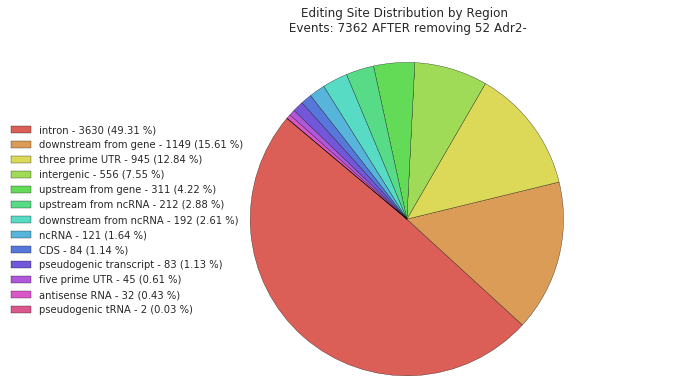

In [19]:
all_annotations = pd.concat(
    [wt_forward_annotations, wt_reverse_annotations]
)
all_falsepositives = reverse_falsepositives + forward_falsepositives
plot_pie(all_annotations, all_falsepositives, all_output_regions_piechart)
all_annotations.to_csv(
    all_output_regions_annotations,
    sep='\t',
    index=None,
)

# Print the false positives and look to see if they make sense...

In [20]:
print(forward_falsepositives, reverse_falsepositives)

(['chrIV:15909267', 'chrII:8059075', 'chrX:4459293', 'chrII:7123998', 'chrII:11216020', 'chrII:7123751', 'chrII:3817205', 'chrIV:5716594', 'chrIII:12944196', 'chrIV:7595254', 'chrV:20301517', 'chrIV:15909269', 'chrI:6560745', 'chrI:9972129', 'chrom', 'pos', 'num_reads', 'ref', 'alt', 'conf', 'post_pseudocount', 'pre_pseudocount', 'filter', 'info', 'format', 'baz'], ['chrV:5581406', 'chrIII:3061583', 'chrI:10819312', 'chrX:2095954', 'chrIV:10177378', 'chrI:10271089', 'chrII:8031384', 'chrII:3335473', 'chrI:10819272', 'chrI:10819271', 'chrX:237229', 'chrI:10819329', 'chrIII:13480782', 'chrIII:4252921', 'chrom', 'pos', 'num_reads', 'ref', 'alt', 'conf', 'post_pseudocount', 'pre_pseudocount', 'filter', 'info', 'format', 'baz'])


# Add wbgenes

In [21]:
def get_wbgene(row):
    """
    Return the wb gene id based on the id in the annotation file
    Some IDs were not caught because of discrepancies, so these need to be manually curated.
    """
    
    # exception: the true annotation is R10E8.1a, but the actual associated wbgene id is for R10E8.1
    if row['id'][:-1] == 'R10E8.1':
        return 'WBGene00011207'
    # exception: the true annotation is Y73B3A.3b, but the actual associated wbgene id is for Y73B3A.3
    if row['id'][:-1] == 'Y73B3A.3':
        return 'WBGene00022205'
    # exception: the true annotation is T14G10.2, but the actual associated wbgene id is for Y73B3A.3
    if row['id'] == 'T14G10.2e':
        return 'WBGene00004254'
    if row['id'] == 'W06H8.8f':
        return 'WBGene00006436'
    if row['id'].startswith('WBGene'):
        return row['id']
    idlist = name2id_dict[row['id']]
    if len(idlist) == 0:
        idlist = name2mrna_dict[row['id']]
        
    idlist_string = ','.join(idlist)
    
    if len(idlist) == 0:
        if row['region'] == 'intergenic':
            return row['id']
    return idlist_string

def add_name(row, col='wbgene'):
    """
    Given an ID, return the name using the database file above.
    """
    if row[col] != '' and row[col] in id2name_dict.keys():
        name = id2name_dict[row[col]]
        return name
    else:
        return ''

In [22]:
all_annotations['wbgene'] = all_annotations.apply(get_wbgene,axis=1)
all_annotations['gene'] = all_annotations.apply(add_name,axis=1)

In [23]:
all_annotations.to_csv(
    all_output_regions_wbgene_annotations,
    sep='\t',
    index=None,
)

# Give wbgene names to other discovered transcripts
- transform existing editing sites (from other papers) into their wbgene name, to compare to our calls.

In [24]:
genes_from_sarah = pd.read_table(
    existing_transcripts,
    names=['transcript1','name1','transcript2','name2','transcript3','name3']
)
genes_from_sarah.fillna('.',inplace=True)
genes_from_sarah.head()

,transcript1,name1,transcript2,name2,transcript3,name3
0,3R5.1,.,3R5.1,.,2L52.1,.
1,3R5.1,.,3R5.1,.,2L52.1,.
2,3R5.1,.,B0035.14,.,2L52.1,.
3,3R5.1,.,B0041.5,.,2L52.1,.
4,3R5.1,.,B0281.1,.,2RSSE.1,.


In [25]:
def name2id(row, col='transcript1'):
    if row[col] == '.':
        return '.'
    else:
        ret = name2id_dict[row[col]]
    if len(ret) == 0:
        return '.'
    else:
        return ret[0]
    
def add_name(row, col='wbgene1'):
    if row[col] == '.':
        return '.'
    else:
        ret = id2name_dict[row[col]]
    if len(ret) == 0:
        return '.'
    else:
        return ret

In [26]:
progress = tnrange(6)
genes_from_sarah['wbgene1'] = genes_from_sarah.apply(name2id, axis=1, args=['transcript1'])
progress.update(1)
genes_from_sarah['wbgene2'] = genes_from_sarah.apply(name2id, axis=1, args=['transcript2'])
progress.update(1)
genes_from_sarah['wbgene3'] = genes_from_sarah.apply(name2id, axis=1, args=['transcript3'])
progress.update(1)
genes_from_sarah['name1'] = genes_from_sarah.apply(add_name, axis=1, args=['wbgene1'])
progress.update(1)
genes_from_sarah['name2'] = genes_from_sarah.apply(add_name, axis=1, args=['wbgene2'])
progress.update(1)
genes_from_sarah['name3'] = genes_from_sarah.apply(add_name, axis=1, args=['wbgene3'])
progress.update(1)
genes_from_sarah.head()

,transcript1,name1,transcript2,name2,transcript3,name3,wbgene1,wbgene2,wbgene3
0,3R5.1,pot-3,3R5.1,pot-3,2L52.1,2L52.1,WBGene00007065,WBGene00007065,WBGene00007063
1,3R5.1,pot-3,3R5.1,pot-3,2L52.1,2L52.1,WBGene00007065,WBGene00007065,WBGene00007063
2,3R5.1,pot-3,B0035.14,dnj-1,2L52.1,2L52.1,WBGene00007065,WBGene00001019,WBGene00007063
3,3R5.1,pot-3,B0041.5,B0041.5,2L52.1,2L52.1,WBGene00007065,WBGene00015009,WBGene00007063
4,3R5.1,pot-3,B0281.1,B0281.1,2RSSE.1,2RSSE.1,WBGene00007065,WBGene00015108,WBGene00007064


# Get list of already discovered edited genes and compare against ours
- get unique set of gene names known to be edited from previous manuscripts
- print number of edited genes

In [27]:
g1 = list(set(genes_from_sarah['wbgene1']))
g2 = list(set(genes_from_sarah['wbgene2']))
g3 = list(set(genes_from_sarah['wbgene3']))

g_all = []
g_all.append(g1)
g_all.append(g2)
g_all.append(g3)
g = [item for sublist in g_all for item in sublist]
g = set(g)
len(g)

8909

<matplotlib_venn._common.VennDiagram instance at 0x2ab3e80cc128>

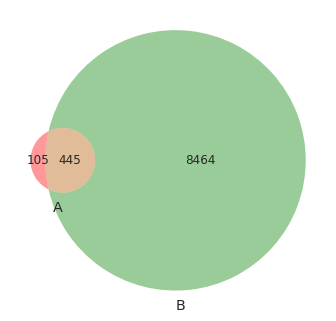

In [28]:
all_annotations_no_intergenic = all_annotations[all_annotations['region']!='intergenic']

our_n = set(all_annotations_no_intergenic['gene'])
our_g = set(all_annotations_no_intergenic['wbgene'])
from matplotlib_venn import venn2, venn3
venn2([our_g,g])

In [29]:
len(our_g - g)

105

In [30]:
with open(supplemental_doc1_genes, 'w') as f:
    f.write("Genes Identified as Edited\n")
    f.write("Wormbase ID\tGene Name\n")
    for gene in our_g:
        f.write('{}\t{}\n'.format(gene,id2name_dict[gene]))
with open(supplemental_doc1_novel, 'w') as f:
    f.write("Novel Genes Identified as Edited\n")
    f.write("Wormbase ID\tGene Name\n")
    for gene in (our_g - g):
        f.write('{}\t{}\n'.format(gene,id2name_dict[gene]))

In [31]:
genes_from_sarah[
    ['transcript1','wbgene1','name1','transcript2','wbgene2','name2','transcript3','wbgene3','name3']
].to_csv(
    existing_transcripts_wbgene,
    sep='\t',
    index=None,
)

# Check to see how many genes were edited

In [32]:
pd.options.display.max_rows = 999
all_annotations_no_intergenic = all_annotations[all_annotations['region']!='intergenic']
all_annotations_no_intergenic['region'].value_counts()

intron                    3630
downstream from gene      1149
three prime UTR            945
upstream from gene         311
upstream from ncRNA        212
downstream from ncRNA      192
ncRNA                      121
CDS                         84
pseudogenic transcript      83
five prime UTR              45
antisense RNA               32
pseudogenic tRNA             2
Name: region, dtype: int64

In [33]:
print("Number of edited genes: {}".format(len(set(all_annotations_no_intergenic['gene']))))

Number of edited genes: 550


In [34]:
# check to see that we've assigned all genic regions. Some may be missed due to inexact matching of IDs in database
all_annotations_no_intergenic[all_annotations_no_intergenic['gene']=='']

,chrom,pos-1,pos,approx_edit_fraction,approx_coverage,strand,region_chrom,source,region_start,region_end,region_strand,attributes,region,id,wbgene,gene


# Check against validated sanger editing

In [35]:
# this was the original validation table - we now need to compare the current (0.0.3 pipeline) set with the original (0.0.2) results. 
validated_sites = pd.read_table(
    validated_events_from_sarah,
    sep='\t'
)
validated_sites.head()

,Gene,Chromosome,Editing site position,% edited (RNA seq),Identified in Sanger Sequencing,Predicted by RNA-Seq Pipeline
0,crtc-1,chrI,2033866,NaN,Yes,No
1,crtc-1,chrI,2033878,72.0,Yes,Yes
2,crtc-1,chrI,2033879,10.0,Yes,Yes
3,crtc-1,chrI,2033881,12.0,Yes,Yes
4,crtc-1,chrI,2033888,38.0,Yes,Yes


# Append current annotations to validated dataframe and compare
- should be mostly identical
- differences should come only from changes in pipeline filters

In [36]:
all_annotations_edit_frac = all_annotations[['chrom','pos','approx_edit_fraction']]
all_annotations_edit_frac.columns = ['Chromosome', 'Editing site position', '0.0.3 % edited (RNA seq)']
validated_df = pd.merge(
    all_annotations_edit_frac, 
    validated_sites, 
    how='right', 
    # on=['Chromosome','Editing site position']
    left_on=['Chromosome', 'Editing site position'], 
    right_on=['Chromosome','Editing site position']
)
validated_df.to_csv(validation_comparisons,sep='\t', index=None)
validated_df

,Chromosome,Editing site position,0.0.3 % edited (RNA seq),Gene,% edited (RNA seq),Identified in Sanger Sequencing,Predicted by RNA-Seq Pipeline
0,chrI,2033879.0,10.0,crtc-1,10.0,Yes,Yes
1,chrI,2033878.0,72.0,crtc-1,72.0,Yes,Yes
2,chrI,2033881.0,12.0,crtc-1,12.0,Yes,Yes
3,chrI,2033888.0,38.0,crtc-1,38.0,Yes,Yes
4,chrI,2033911.0,13.0,crtc-1,13.0,Yes,Yes
5,chrIII,6702036.0,10.0,rbf-1,10.0,Yes,Yes
6,chrIII,6701762.0,25.0,rbf-1,25.0,Yes,Yes
7,chrIII,6701765.0,88.0,rbf-1,88.0,Yes,Yes
8,chrIII,6701766.0,34.0,rbf-1,34.0,Yes,Yes
9,chrIII,6701757.0,58.0,rbf-1,58.0,Yes,Yes


# Compare editing sites discovered by validation (Sanger) that were not picked up by our pipeline

In [37]:
vdf = validated_df.fillna('NONE')
print("Number of sites not captured by pipeline but discovered to be edited via sanger: {}".format(vdf[
    (vdf['Identified in Sanger Sequencing']=='Yes') &
    (vdf['0.0.3 % edited (RNA seq)']=='NONE')
].shape[0]))
print("Number of sites captured by pipeline AND discovered to be edited via sanger: {}".format(vdf[
    (vdf['Identified in Sanger Sequencing']=='Yes') &
    (vdf['0.0.3 % edited (RNA seq)']!='NONE')
].shape[0]))

Number of sites not captured by pipeline but discovered to be edited via sanger: 87
Number of sites captured by pipeline AND discovered to be edited via sanger: 86


In [38]:
# Number of sites captured by the pipeline against Sanger validations
validated_df.dropna(subset=['0.0.3 % edited (RNA seq)'])['Identified in Sanger Sequencing'].value_counts()
validated_df

,Chromosome,Editing site position,0.0.3 % edited (RNA seq),Gene,% edited (RNA seq),Identified in Sanger Sequencing,Predicted by RNA-Seq Pipeline
0,chrI,2033879.0,10.0,crtc-1,10.0,Yes,Yes
1,chrI,2033878.0,72.0,crtc-1,72.0,Yes,Yes
2,chrI,2033881.0,12.0,crtc-1,12.0,Yes,Yes
3,chrI,2033888.0,38.0,crtc-1,38.0,Yes,Yes
4,chrI,2033911.0,13.0,crtc-1,13.0,Yes,Yes
5,chrIII,6702036.0,10.0,rbf-1,10.0,Yes,Yes
6,chrIII,6701762.0,25.0,rbf-1,25.0,Yes,Yes
7,chrIII,6701765.0,88.0,rbf-1,88.0,Yes,Yes
8,chrIII,6701766.0,34.0,rbf-1,34.0,Yes,Yes
9,chrIII,6701757.0,58.0,rbf-1,58.0,Yes,Yes


In [39]:
verification_table = validated_df[
    ['Gene','Chromosome','Editing site position','0.0.3 % edited (RNA seq)',
     'Identified in Sanger Sequencing','Predicted by RNA-Seq Pipeline'
    ]
]
verification_table['Editing site position'] = verification_table['Editing site position'].astype(int)
verification_table.columns = [
    'Gene','Chromosome','Editing site position','0.0.3 % edited (RNA seq)','Identified in Sanger Sequencing','Predicted by RNA-Seq pipeline'
]
verification_table.to_csv(supplemental_doc1_sanger, sep='\t', index=False)

/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Check differential expression output

In [40]:
deseq2_df = pd.read_table(from_deseq2)
deseq2_df.sort_values(by='padj',inplace=True)
l2fc_threshold = 1

In [41]:
print(
    "Number of upregulated genes (with respect to WT): {}".format(
        deseq2_df[(deseq2_df['log2FoldChange']>=l2fc_threshold)].shape[0]
    )
)#  & (deseq2_df['padj']<0.05)].shape
print(
    "Number of downregulated genes (with respect to WT): {}".format(
        deseq2_df[(deseq2_df['log2FoldChange']<=-l2fc_threshold)].shape[0]
    )
)#  & (deseq2_df['padj']<0.05)].shape

Number of upregulated genes (with respect to WT): 76
Number of downregulated genes (with respect to WT): 93


# Check against qPCR Differential Expression validated results:
- These should not change no matter what annotation we use.

In [42]:
for i in range(0,len(VALIDATED)):
    print(id2name_dict[VALIDATED[i]], pd.DataFrame(deseq2_df.ix[VALIDATED[i]]).T) # clec-41 (should be downregulated)

('clec-41',                   baseMean  log2FoldChange    lfcSE      stat    pvalue  \
WBGene00007153  635.076884       -1.070762  0.30647 -3.493854  0.000476   

                    padj  
WBGene00007153  0.077637  )
('ctl-2',                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
WBGene00000831  3338.713976       -1.334024  0.344759 -3.869435  0.000109   

                    padj  
WBGene00000831  0.032242  )
('dod-19',                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
WBGene00022644  1770.798683       -1.481889  0.337127 -4.395641  0.000011   

                    padj  
WBGene00022644  0.011607  )
('hsp-12.6',                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
WBGene00002013  487.682639        1.828016  0.389449  4.693854  0.000003   

                    padj  
WBGene00002013  0.008452  )
('sre-6',                   baseMean  log2FoldChange     lfcSE     stat    pvalue  \
WBGene00009242  257.789711        1

In [43]:
pd.DataFrame(deseq2_df.ix['WBGene00000831']).T # ctl-2 (should be downregulated)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
WBGene00000831,3338.713976,-1.334024,0.344759,-3.869435,0.000109,0.032242


In [44]:
pd.DataFrame(deseq2_df.ix['WBGene00022644']).T # dod-19 (should be downregulated)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
WBGene00022644,1770.798683,-1.481889,0.337127,-4.395641,0.000011,0.011607


In [45]:
pd.DataFrame(deseq2_df.ix['WBGene00002013']).T # hsp-12.6 (should be upregulated)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
WBGene00002013,487.682639,1.828016,0.389449,4.693854,0.000003,0.008452


In [46]:
pd.DataFrame(deseq2_df.ix['WBGene00009242']).T # sre-6 (should be upregulated)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
WBGene00009242,257.789711,1.298609,0.314324,4.13144,0.000036,0.019874


# Check the number of genes DE that were edited

In [47]:
upregulated = deseq2_df[(deseq2_df['log2FoldChange']>=1)] # this was criteria for filtering
downregulated = deseq2_df[(deseq2_df['log2FoldChange']<=-1)] # this was criteria for filtering
upregulated_genes = set(list(upregulated.index))
downregulated_genes = set(list(downregulated.index))
edited_genes = set(list(all_annotations_no_intergenic['wbgene']))
print("DOWNREGULATED + EDITED GENES")
for gene in downregulated_genes.intersection(edited_genes):
    print(gene, id2name_dict[gene])
print("UPREGULATED + EDITED GENES")
for gene in upregulated_genes.intersection(edited_genes):
    print(gene, id2name_dict[gene])

DOWNREGULATED + EDITED GENES
('WBGene00007153', 'clec-41')
('WBGene00000081', 'ads-1')
UPREGULATED + EDITED GENES
('WBGene00022370', 'Y92H12BR.4')
('WBGene00018204', 'F39F10.4')


In [48]:
adr1_list = pd.read_table(
    adr_common_targets_list,
)
ADR1_LIST = list(adr1_list['Common targets'])

# Check number of genes involved in chemotaxis that are edited

In [49]:
def bound_by_adr1(row, adr1_list=ADR1_LIST):
    if row['gene'] in adr1_list:
        return 'Yes'
    else:
        return ''
    
GO_TERMS = [
    'GO:0040011',
    'GO:0043058',
    'GO:0040012',
    'GO:0006935',
    'GO:0040017',
    'GO:0043059',
    'GO:0050919'
] # these are GO terms that are associated with chemotaxis and locomotion
go = go_association_file
go_df = pd.read_table(go, comment='!', sep='\t', names=range(0,17))
go_df = go_df[go_df[4].isin(GO_TERMS)]
go_df_genes = list(set(go_df[1]))
genes_in_go = all_annotations[
    (all_annotations['wbgene'].isin(go_df_genes)) & (all_annotations['region']!='intergenic')
]
genes_in_go = genes_in_go[['wbgene','gene']]
genes_in_go.drop_duplicates(inplace=True)

/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [50]:
genes_in_go['Bound by Adr-1'] = genes_in_go.apply(bound_by_adr1, axis=1)
genes_in_go.columns = ['Wormbase ID','Gene','Bound by Adr-1']
genes_in_go.to_csv(supplemental_doc1_locomotion, sep='\t', index=False)

In [51]:
all_annotations[
    (all_annotations['wbgene'].isin(go_df_genes)) & (all_annotations['region']!='intergenic')
].to_csv(chemotaxis_locomotion_goterms,sep='\t')

# Look at individual editing site calls for our gene of interest (clec-41)

In [52]:
gene = 'clec-41'
print("Number of editing sites found in gene {}: {}".format(
        gene, all_annotations[all_annotations['gene']==gene].shape[0]
    )
     )
all_annotations[all_annotations['gene']==gene]

Number of editing sites found in gene clec-41: 9


,chrom,pos-1,pos,approx_edit_fraction,approx_coverage,strand,region_chrom,source,region_start,region_end,region_strand,attributes,region,id,wbgene,gene
21922,chrV,13135914,13135915,45,22,-,chrV,WormBase,13135820,13135944,-,Parent=Transcript:B0365.6.3,three prime UTR,B0365.6.3,WBGene00007153,clec-41
21819,chrV,13135041,13135042,40,5,-,chrV,WormBase,13134965,13135124,-,Parent=Transcript:B0365.6.2,three prime UTR,B0365.6.2,WBGene00007153,clec-41
21882,chrV,13135854,13135855,66,6,-,chrV,WormBase,13135820,13135944,-,Parent=Transcript:B0365.6.4,three prime UTR,B0365.6.4,WBGene00007153,clec-41
21892,chrV,13135860,13135861,25,8,-,chrV,WormBase,13135749,13135944,-,Parent=Transcript:B0365.6.1,three prime UTR,B0365.6.1,WBGene00007153,clec-41
21905,chrV,13135913,13135914,18,22,-,chrV,WormBase,13135749,13135944,-,Parent=Transcript:B0365.6.1,three prime UTR,B0365.6.1,WBGene00007153,clec-41
21873,chrV,13135853,13135854,83,6,-,chrV,WormBase,13135843,13135944,-,Parent=Transcript:B0365.6.2,three prime UTR,B0365.6.2,WBGene00007153,clec-41
21829,chrV,13135042,13135043,40,5,-,chrV,WormBase,13134965,13135124,-,Parent=Transcript:B0365.6.2,three prime UTR,B0365.6.2,WBGene00007153,clec-41
21839,chrV,13135048,13135049,40,5,-,chrV,WormBase,13134965,13135124,-,Parent=Transcript:B0365.6.2,three prime UTR,B0365.6.2,WBGene00007153,clec-41
21856,chrV,13135848,13135849,50,6,-,chrV,WormBase,13135820,13135944,-,Parent=Transcript:B0365.6.4,three prime UTR,B0365.6.4,WBGene00007153,clec-41


# Generate supplemental table 1

In [53]:
table_s1 = all_annotations[['chrom','pos','approx_edit_fraction','approx_coverage','region','wbgene','gene']]
table_s1.columns = ['Chromosome','Position','% Edit','Coverage','Region','Wormbase ID','Gene Name']
table_s1.to_csv(supplemental_doc1_edited_genes, sep='\t', index=None)

# Generate supplemental table 2

In [54]:
deseq2_df = pd.read_table(
    from_deseq2, names=['Wormbase ID','baseMean','log2FoldChange','lfcSE','stat','pvalue','adjusted p-value'],skiprows=1
)

del deseq2_df['pvalue']
del deseq2_df['stat']
del deseq2_df['lfcSE']

l2fc_threshold = 1

def fold_ratio(row):
    return math.pow(2, row['log2FoldChange'])

def add_gene_name(row):
    return id2name_dict[row['Wormbase ID']]

def is_validated(row, validated_list=VALIDATED):
    if row['Wormbase ID'] in validated_list:
        return 'Verified'
    else:
        return ''

def is_edited(row, edited_list=list(all_annotations_no_intergenic['wbgene'])):
    if row['Wormbase ID'] in edited_list:
        return 'Edited'
    else:
        return ''

def create_supplemental_doc2(dysregulated_genes):

    dysregulated_genes['Fold Ratio'] = dysregulated_genes.apply(fold_ratio, axis=1)
    dysregulated_genes['Gene'] = dysregulated_genes.apply(add_gene_name, axis=1)
    dysregulated_genes['adjusted p-value'].fillna(1, inplace=True)
    dysregulated_genes['Verified'] = dysregulated_genes.apply(is_validated, axis=1)
    dysregulated_genes['Edited'] = dysregulated_genes.apply(is_edited, axis=1)
    return dysregulated_genes

upregulated_genes = deseq2_df[(deseq2_df['log2FoldChange']>=l2fc_threshold)]
upregulated_genes = create_supplemental_doc2(upregulated_genes)
upregulated_genes[['Gene','Wormbase ID','baseMean','Fold Ratio','adjusted p-value','Verified','Edited']].to_csv(
    supplemental_doc2_upregulated_genes, sep='\t', index=False
)

downregulated_genes = deseq2_df[(deseq2_df['log2FoldChange']<=-l2fc_threshold)]
downregulated_genes = create_supplemental_doc2(downregulated_genes)
downregulated_genes[['Gene','Wormbase ID','baseMean','Fold Ratio','adjusted p-value','Verified','Edited']].to_csv(
    supplemental_doc2_downregulated_genes, sep='\t', index=False
)


/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind